In [ ]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
from keras.models import load_model
model = load_model('/content/cnn_20_epochs.h5')

In [ ]:
# Importing required modules

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.layers as L
from tensorflow.keras.datasets import mnist, cifar10

import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 8s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


# Resnet50

In [ ]:
# scaling the data

X_train_scaled = X_train/255

X_test_scaled = X_test/255

In [ ]:
nb_classes = 10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

In [ ]:
height, width, channels = 32, 32, 3

In [ ]:
from keras.models import load_model
model = load_model('resnet50_keras_94.08.h5')

In [ ]:
# Function to calculate adversary noise
def generate_adversary(image, label, epsilon=0.1):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)
  perturbation = epsilon * sign_grad  # Apply epsilon to the sign gradient

  return perturbation

  # return sign_grad

[4]
True prediction: deer


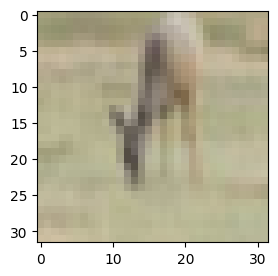

In [ ]:
# Selecting random image for testing
rand_idx = randint(0,10000)
image = X_test_scaled[rand_idx].reshape((1, height, width, channels))
label = y_test[rand_idx]
print(label)

print(f'True prediction: {label_names[label[0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [ ]:
# Adding the adversary noise to image
perturbations = generate_adversary(image,label,0.2).numpy()
adversarial = image + (perturbations * 0.05)

False


1/1 [==============================] - 2s 2s/step
Original Image Prediction: deer
1/1 [==============================] - 0s 44ms/step
Adversary Prediction: deer


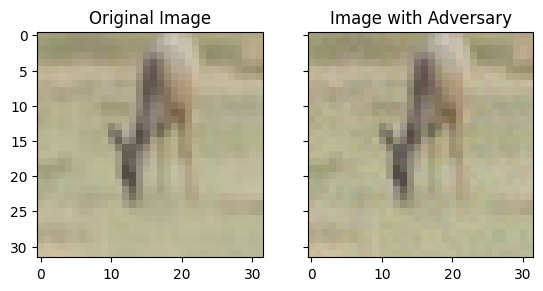

In [ ]:
from art.estimators.classification import KerasClassifier
# Comparing both images
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
print(f'Original Image Prediction: {label_names[model.predict(image).argmax()]}')
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
# Comparing predictions
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")

1/1 [==============================] - 0s 24ms/step
Normal Image Prediction: deer
1/1 [==============================] - 0s 23ms/step
Adversary Prediction: deer


In [ ]:
# Function to generate batch of images with adversary
def adversary_generator(batch_size):
  while True:
    images = []
    labels = []
    for batch in range(batch_size):
      # N = randint(0, 10000)
      label = y_test[batch]
      image = X_test_scaled[batch].reshape((1,height, width, channels))

      perturbations = generate_adversary(image, label, 0.2).numpy()
      adversarial = image + (perturbations * 0.2)

      images.append(adversarial)
      labels.append(label)

      if batch%1000 == 0:
        print(f"{batch} images generated")

    images = np.asarray(images).reshape((batch_size, height, width, channels))
    labels = np.asarray(labels)

    yield images, labels

In [ ]:
# Testing model accuracy on adversarial examples
x_adversarial, y_adversarial = next(adversary_generator(10000))

0 images generated
1000 images generated
2000 images generated
3000 images generated
4000 images generated
5000 images generated
6000 images generated
7000 images generated
8000 images generated
9000 images generated


In [ ]:
ad_acc = model.evaluate(x_adversarial, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples: {ad_acc[1]*100}")

Accuracy on Adversarial Examples: 75.3600001335144


In [ ]:
np.array_equal(y_test, y_adversarial)

True

In [ ]:
predictions = model.predict(x_adversarial)

313/313 [==============================] - 35s 111ms/step


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
predicted_labels.shape

(10000,)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy = accuracy_score(predicted_labels,y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 75.36%


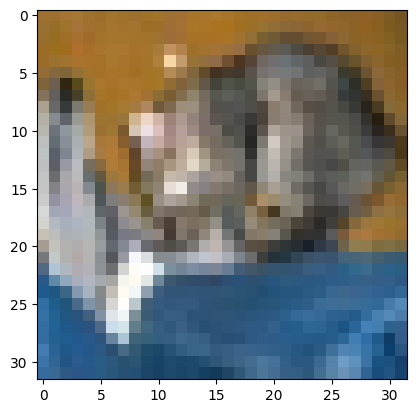

In [ ]:
plt.imshow(X_test_scaled[0])
plt.show()

In [ ]:
model.predict(np.expand_dims(X_test_scaled[0],axis = 0))

1/1 [==============================] - 0s 42ms/step


array([[7.08275824e-04, 7.44917896e-04, 7.66104960e-04, 9.94598746e-01,
        4.66676109e-04, 1.74785883e-03, 1.87506070e-04, 1.09759814e-04,
        5.47495845e-04, 1.22719837e-04]], dtype=float32)

1/1 [==============================] - 0s 42ms/step
Original Image Prediction: cat
1/1 [==============================] - 0s 106ms/step


Adversary Prediction: frog


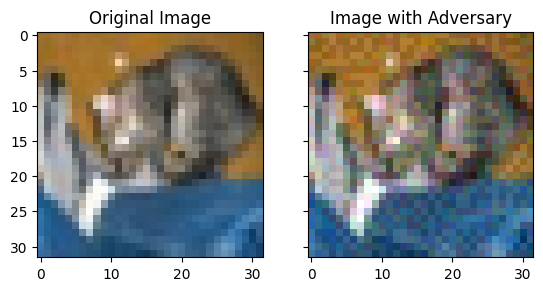

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
print(f'Original Image Prediction: {label_names[model.predict(np.expand_dims(X_test_scaled[0],axis = 0)).argmax()]}')
ax1.imshow(X_test_scaled[0])
ax1.set_title("Original Image")
print(f"Adversary Prediction: {label_names[model.predict(np.expand_dims(x_adversarial[0], axis = 0)).argmax()]}")
ax2.imshow(x_adversarial[0])
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
np.save('X_Resnet50_adv_FGSM.npy', x_adversarial)
np.save('Y_Resnet50_adv_FGSM.npy', predicted_labels)